In [ ]:
%pip install pandas numpy matplotlib scikit-learn seaborn scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


# Автомобильный трафик
В качестве данных для анализа был выбран [датасет](https://www.kaggle.com/datasets/hasibullahaman/traffic-prediction-dataset/data), который предоставляет информацию об автомобильном трафике на перекрестке Абдул-Хака в Кабуле (Афганистан) за период в два месяца.

Данные собираются с помощью алгоритмов компьютерного зрения, которые фиксируют обстановку на данном участке дороги с интервалом в 15 минут.

## Описание датасета
| Название признака     | Тип данных | Описание                                                      |
| --------------------- | ---------- | ------------------------------------------------------------- |
| **Time**              | timestamp  | Время анализа. Только время                                   |
| **Date**              | int        | День в месяце                                                 |
| **Day of the week**   | str        | День недели (Monday, Tuesday ...)                             |
| **CarCount**          | int        | Количество автомобилей, замеченных за 15 минут                |
| **BikeCount**         | int        | Количество мотоциклов, замеченных за 15 минут                 |
| **BusCount**          | int        | Количество автобусов, замеченных за 15 минут                  |
| **TruckCount**        | int        | Количество грузовиков, замеченных за 15 минут                 |
| **Total**             | int        | Общее количество ТС, замеченных за 15 минут                   |
| **Traffic Situation** | string     | Статус перекрестка (low, normal, high, heavy)                 |

### Номинальные признаки
- **Day of the week**
- **Traffic Situation**

### Порядковые признаки
- **Date**

### Интервальная признаки
- **Time** (Циклическая шкала)

### Относительные признаки
- **CarCount**
- **BikeCount**
- **BusCount**  
- **TruckCount**
- **Total** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.simplefilter('ignore', InterpolationWarning)
warnings.simplefilter('ignore', FutureWarning)

source = pd.read_csv('./data/source.csv')
source.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal


In [2]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               5952 non-null   object
 1   Date               5952 non-null   int64 
 2   Day of the week    5952 non-null   object
 3   CarCount           5952 non-null   int64 
 4   BikeCount          5952 non-null   int64 
 5   BusCount           5952 non-null   int64 
 6   TruckCount         5952 non-null   int64 
 7   Total              5952 non-null   int64 
 8   Traffic Situation  5952 non-null   object
dtypes: int64(6), object(3)
memory usage: 418.6+ KB


In [3]:
source.duplicated().any()

False

In [4]:
source.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000
mean,16.000000,65.440692,12.161458,12.912970,18.646337,109.161458
std,8.945023,44.749335,11.537944,12.497736,10.973139,55.996312
min,1.000000,5.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,18.750000,3.000000,2.000000,10.000000,54.000000
50%,16.000000,62.000000,9.000000,10.000000,18.000000,104.000000
75%,24.000000,103.000000,19.000000,20.000000,27.000000,153.000000
max,31.000000,180.000000,70.000000,50.000000,60.000000,279.000000


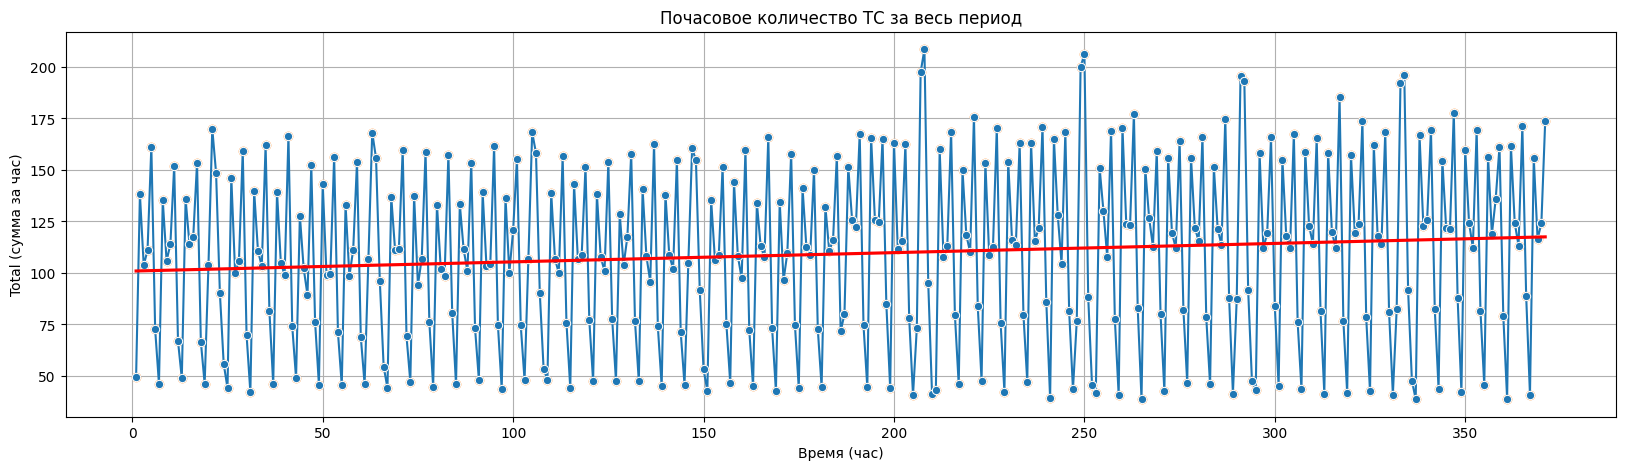

In [2]:
y = source['Total'].rolling(window=16, step=16).mean()
x = list(range(0, len(y)))

plt.figure(figsize=(20, 5))
sns.lineplot(y=y, x=x, marker="o", linestyle="-")
sns.regplot(x=x, y=y, ci=False, line_kws={'color':'red'})
plt.title("Почасовое количество ТС за весь период")
plt.xlabel("Время (час)")
plt.ylabel("Total (сумма за час)")
plt.grid(True)
plt.show()

In [6]:
total_not_equals_sum = source[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']].sum(axis=1) != source['Total']
total_not_equals_sum.any()

False

In [7]:
intervals = source[['Total', 'Traffic Situation']].groupby('Traffic Situation')['Total'].agg(['count', 'min', 'max']).reindex(['low', 'normal', 'high', 'heavy'])
intervals

,count,min,max
Traffic Situation,,,
low,834,21,167
normal,3610,26,223
high,371,112,166
heavy,1137,168,279


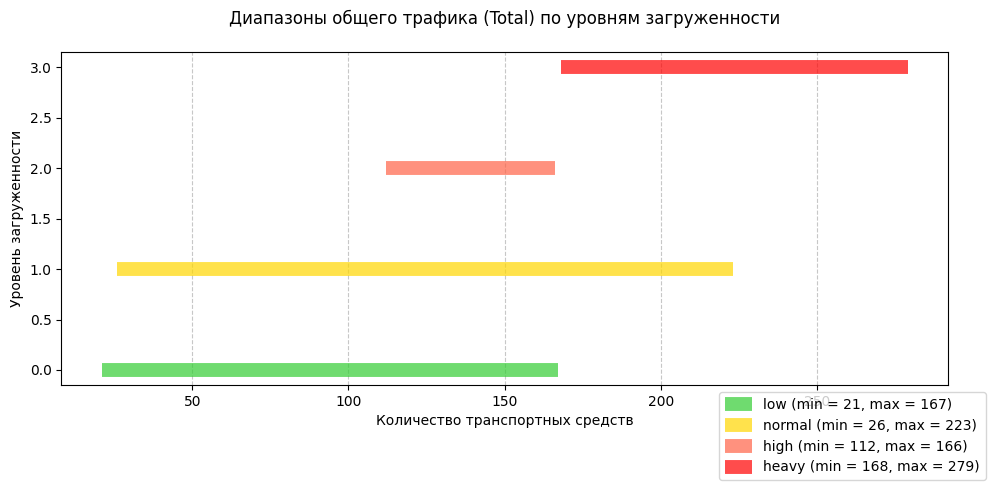

In [8]:
plt.figure(figsize=(10, 5))
# Цвета для разных уровней трафика
colors = {'low': 'limegreen', 'normal': 'gold', 'high': 'tomato', 'heavy': 'red'}

for idx, level in enumerate(intervals.index):
    plt.hlines(y=idx, 
               xmin=intervals.loc[level, 'min'], 
               xmax=intervals.loc[level, 'max'],
               linewidth=10,
               alpha=0.7,
               colors=colors[level],
               label=f'{level} (min = {intervals.loc[level, 'min']}, max = {intervals.loc[level, 'max']})')
    
plt.title('Диапазоны общего трафика (Total) по уровням загруженности', pad=20)
plt.xlabel('Количество транспортных средств')
plt.ylabel('Уровень загруженности')
plt.legend(bbox_to_anchor=(1.05, 0))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total vehicle & Traffic Situation')

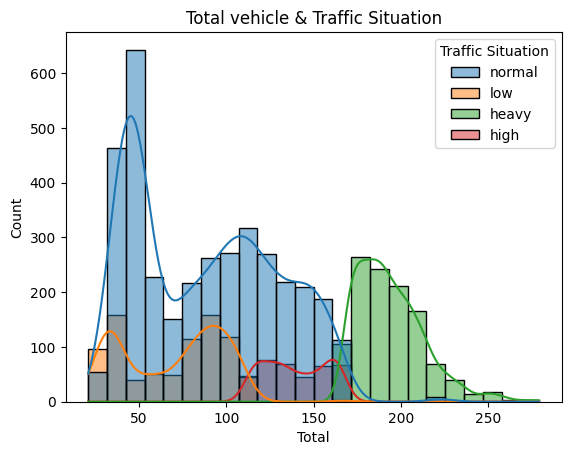

In [9]:
sns.histplot(source, x='Total', hue='Traffic Situation', kde=True)
plt.title('Total vehicle & Traffic Situation')

In [10]:
cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
for col in cols:
    result_adf = adfuller(source[col].dropna(), autolag='AIC', regression='ct')
    print(f"{col}: ADF-статистика = {result_adf[0]}, p-value = {result_adf[1]}")

CarCount: ADF-статистика = -14.832295827847153, p-value = 2.683814001752632e-22
BikeCount: ADF-статистика = -13.636680325759318, p-value = 2.474943483343211e-21
BusCount: ADF-статистика = -14.770114758141911, p-value = 2.9155612678707775e-22
TruckCount: ADF-статистика = -13.43786876615051, p-value = 4.058032621160428e-21
Total: ADF-статистика = -14.720544311542001, p-value = 3.122736017927896e-22


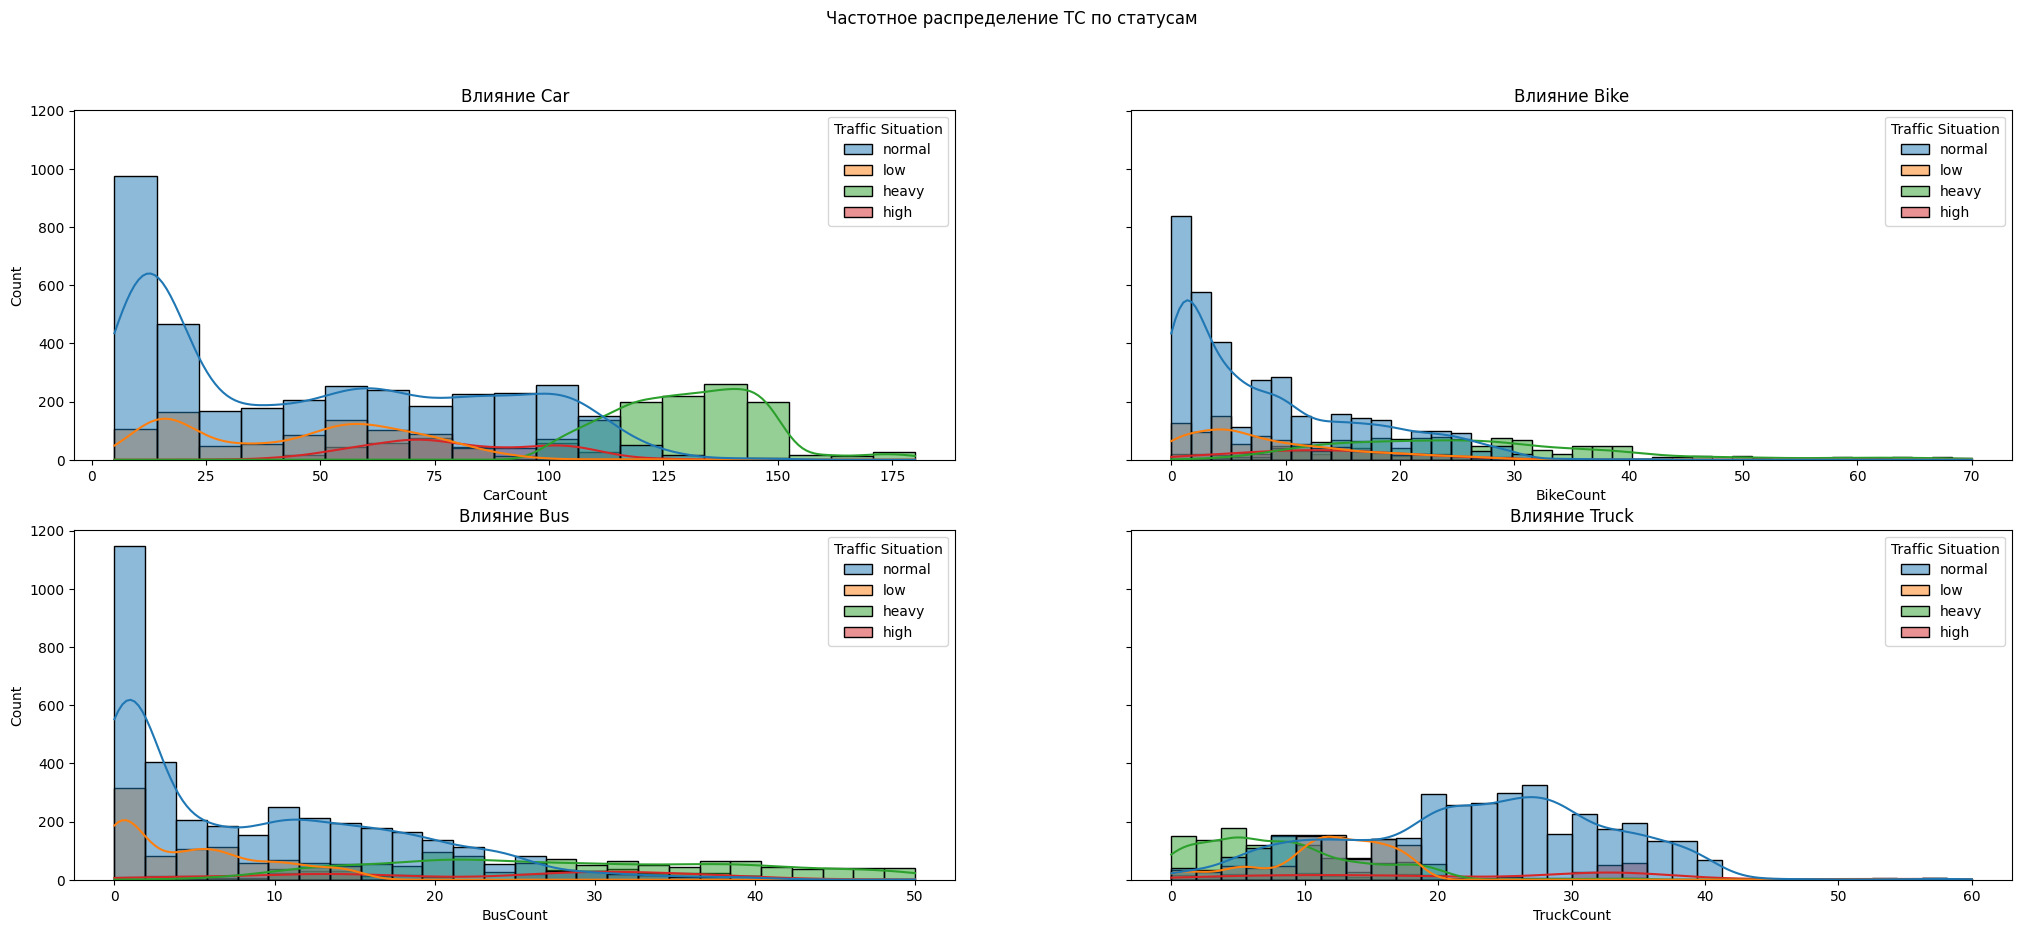

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(25, 10), sharey=True)
fig.suptitle('Частотное распределение ТС по статусам')
sns.histplot(source,x='CarCount',hue='Traffic Situation',kde=True,ax=axes[0,0])
axes[0,0].set_title('Влияние Car')
sns.histplot(source,x='BikeCount',hue='Traffic Situation',kde=True,ax=axes[0,1])
axes[0,1].set_title('Влияние Bike')
sns.histplot(source,x='BusCount',hue='Traffic Situation',kde=True,ax=axes[1,0])
axes[1,0].set_title('Влияние Bus')
sns.histplot(source,x='TruckCount',hue='Traffic Situation',kde=True,ax=axes[1,1])
axes[1,1].set_title('Влияние Truck')
plt.show()

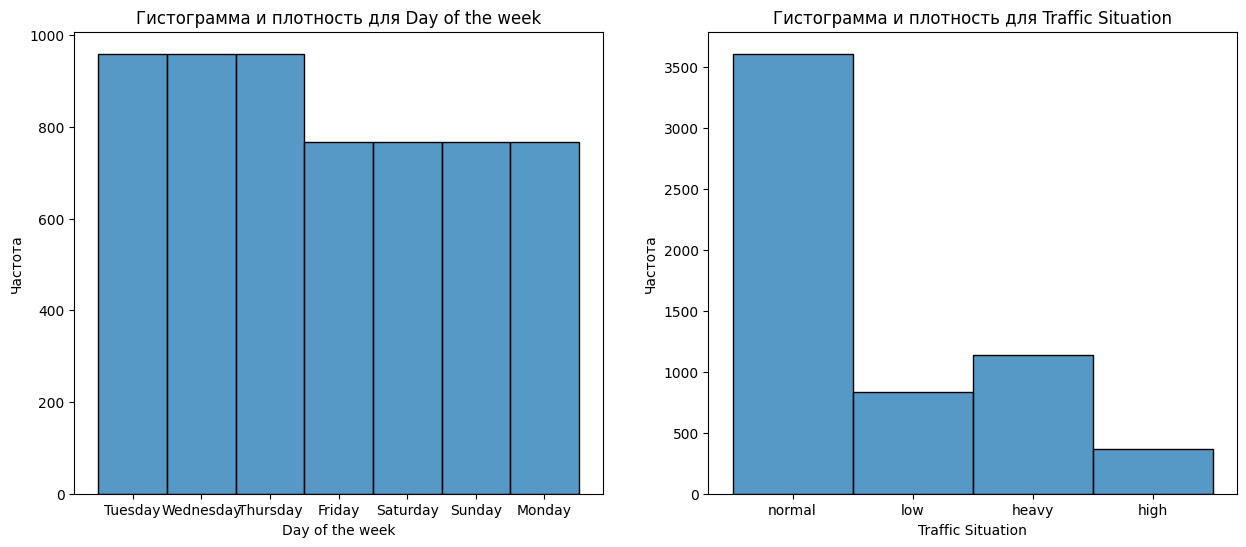

In [12]:
cols = ['Day of the week', 'Traffic Situation']
fig, axes = plt.subplots(1, len(cols), figsize=(15,6))
for i, (ax, col) in enumerate(zip(axes.flatten(), cols)):
    sns.histplot(source[col], ax=ax)
    ax.set_title(f'Гистограмма и плотность для {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')


In [13]:
traffic_order = ['low', 'normal', 'high', 'heavy']
source['Traffic Situation'] = pd.Categorical(source['Traffic Situation'], categories=traffic_order, ordered=True).codes

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
source['Day of the week'] = pd.Categorical(source['Day of the week'], categories=day_order, ordered=True).codes

In [14]:
def sin_cos_transform(X, col, interval):
    X[f'{col}_sin'] = np.sin(2 * np.pi * source[col] / interval)
    X[f'{col}_cos'] = np.cos(2 * np.pi * source[col] / interval)

In [15]:
tmp = pd.to_datetime(source['Time'], format='%I:%M:%S %p')
source['Time_24h'] = tmp.dt.strftime('%H:%M')
source['Hour'] = tmp.dt.hour
source['Minute'] = tmp.dt.minute

sin_cos_transform(source, 'Minute', 60)
sin_cos_transform(source, 'Hour', 24)
sin_cos_transform(source, 'Day of the week', 7)

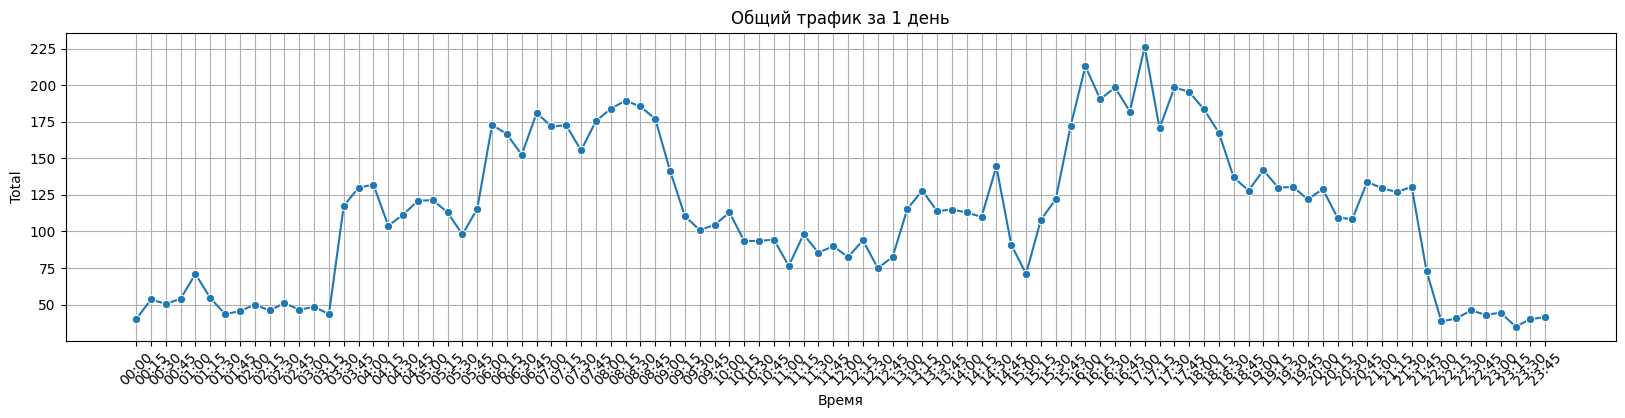

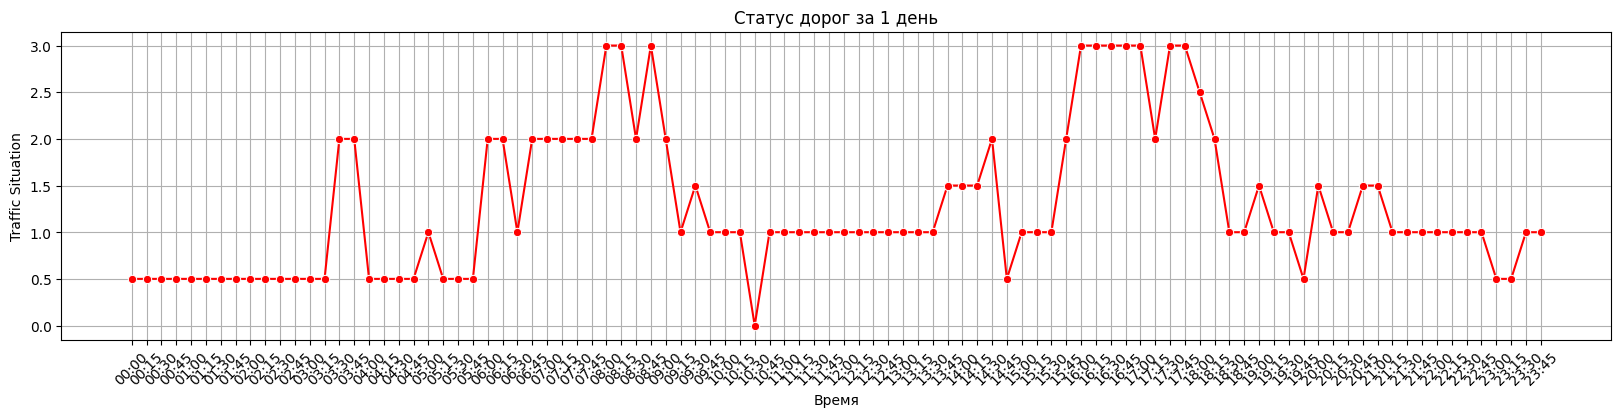

In [16]:
one_day = source[source['Date'] == source['Date'].iloc[0]]

plt.figure(figsize=(20, 4))
sns.lineplot(data=one_day, x='Time_24h', y='Total', marker='o', ci=None)
plt.title('Общий трафик за 1 день')
plt.xlabel('Время')
plt.xticks(rotation=45)
plt.grid()
plt.show()

plt.figure(figsize=(20, 4))
sns.lineplot(data=one_day, x='Time_24h', y='Traffic Situation', marker='o', color='red', ci=None)
plt.title('Статус дорог за 1 день')
plt.xlabel('Время')
plt.xticks(rotation=45)
plt.grid()
plt.show()

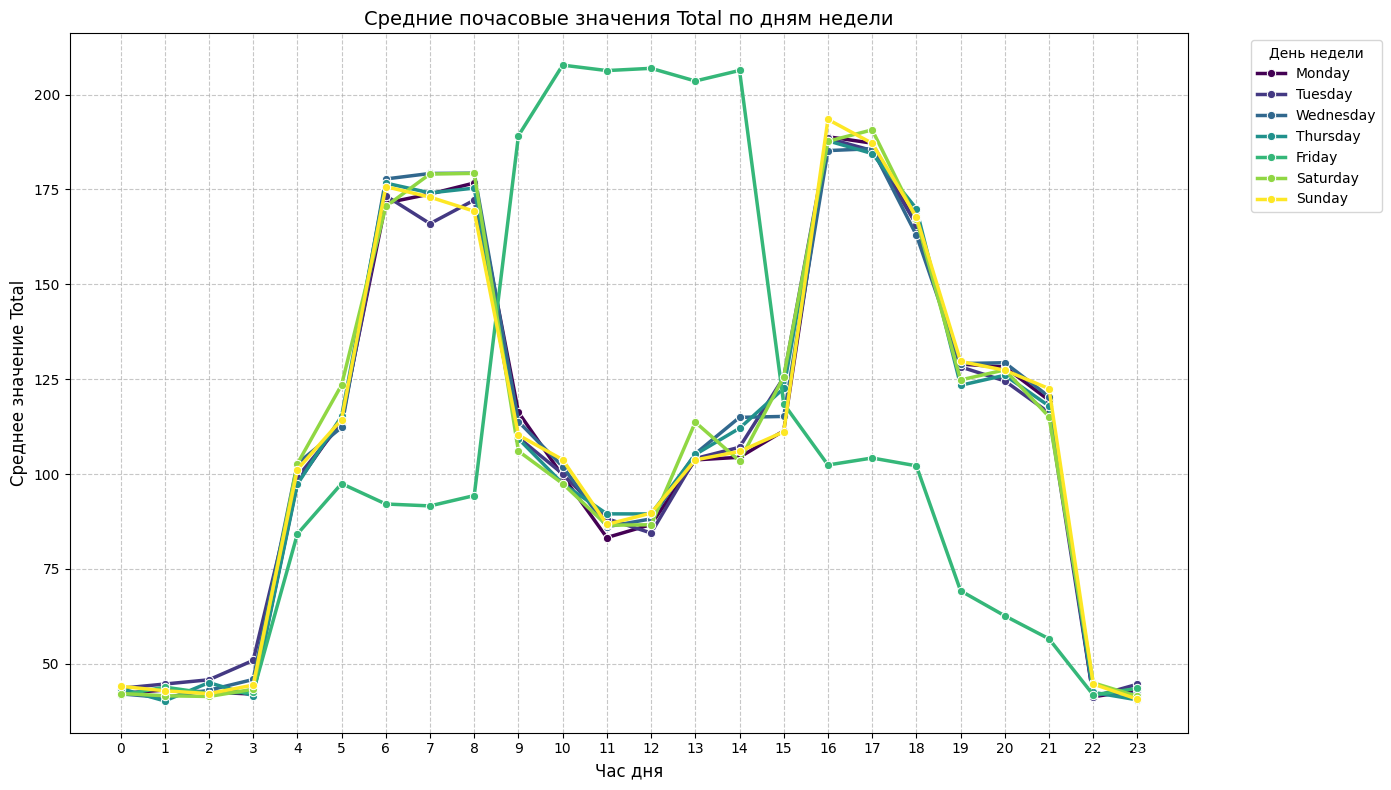

In [17]:
hourly_means = source.groupby(['Day of the week', 'Hour'])['Total'].mean().reset_index()

plt.figure(figsize=(14, 8))

ax = sns.lineplot(data=hourly_means, 
             x='Hour', 
             y='Total', 
             hue='Day of the week',
             palette='viridis',
             linewidth=2.5,
             marker='o')

plt.title('Средние почасовые значения Total по дням недели', fontsize=14)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Среднее значение Total', fontsize=12)
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.7)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, day_order, 
          title='День недели',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
source['IsDay'] = ((source['Hour'] >= 5) & (source['Hour'] < 19)).astype(int)

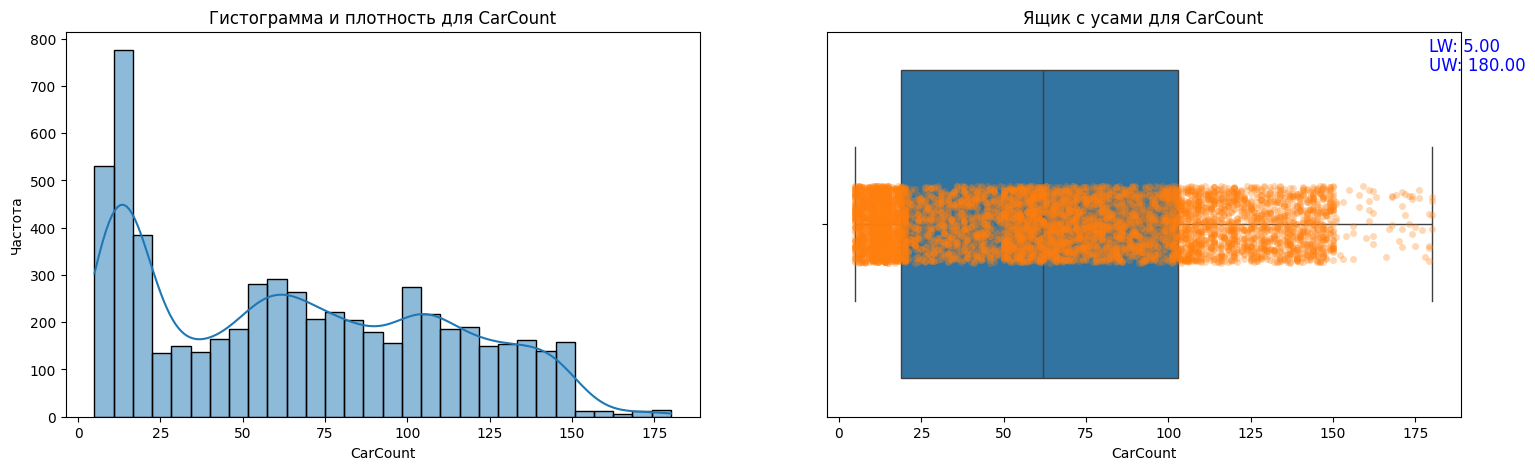

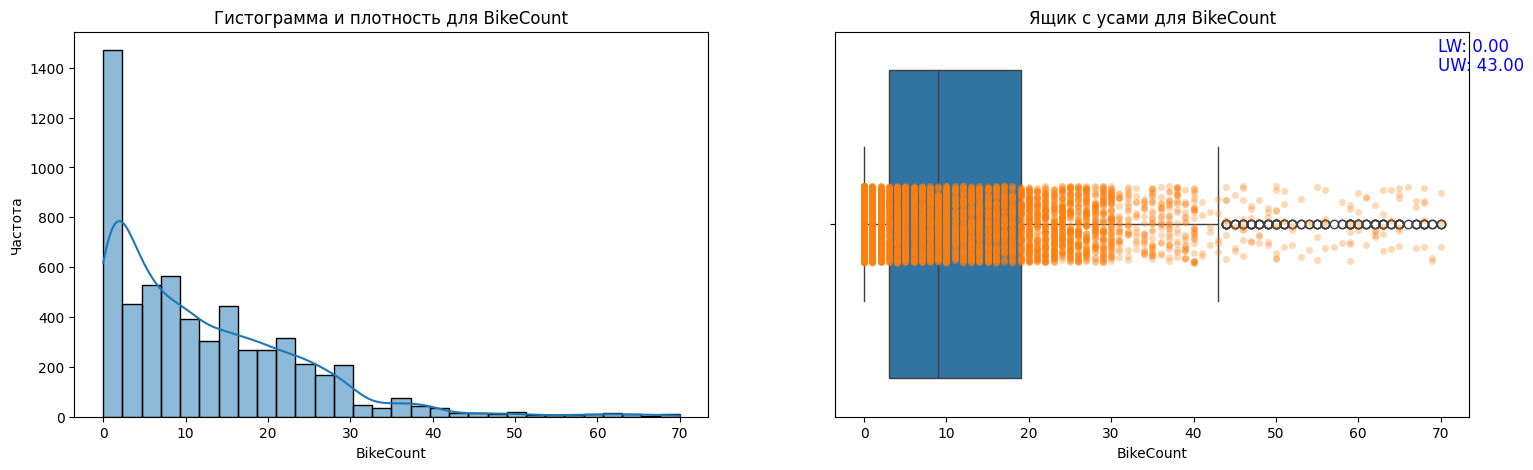

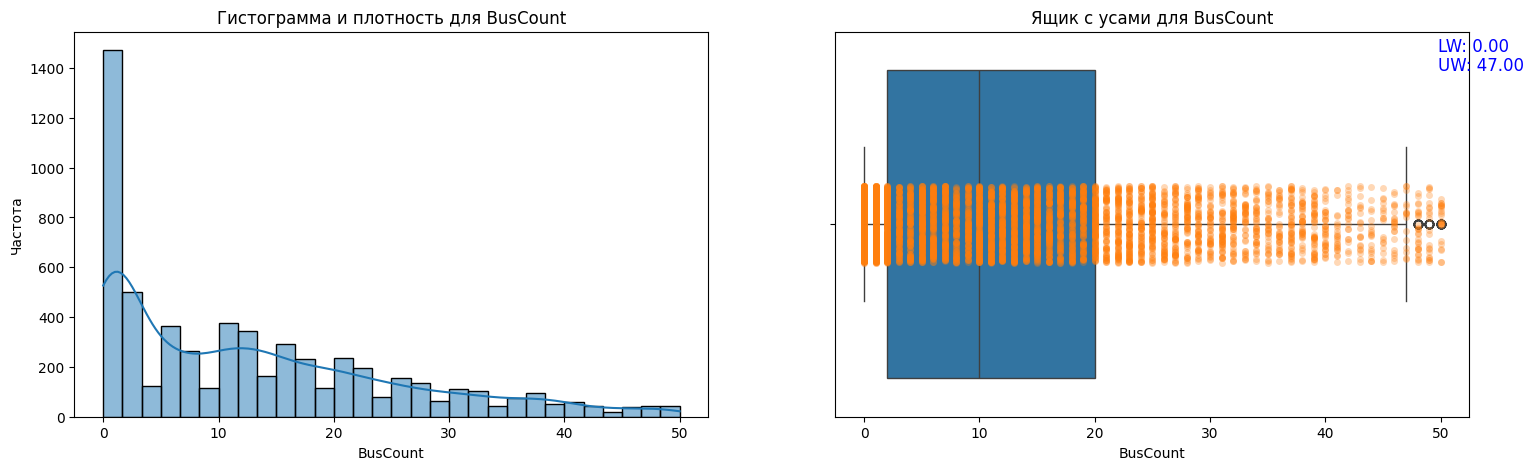

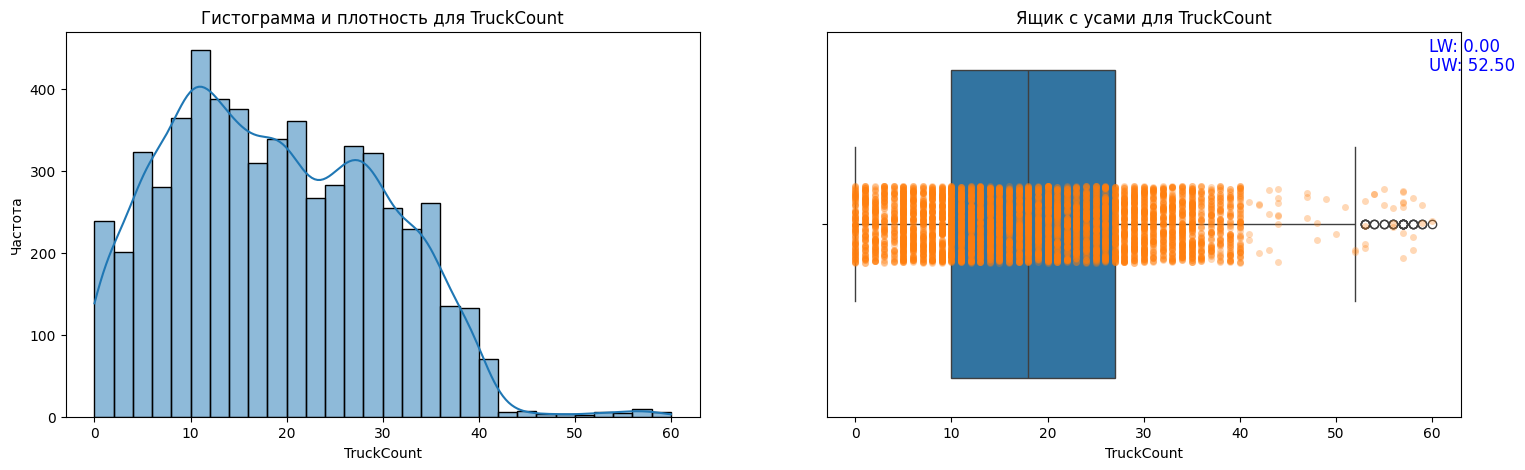

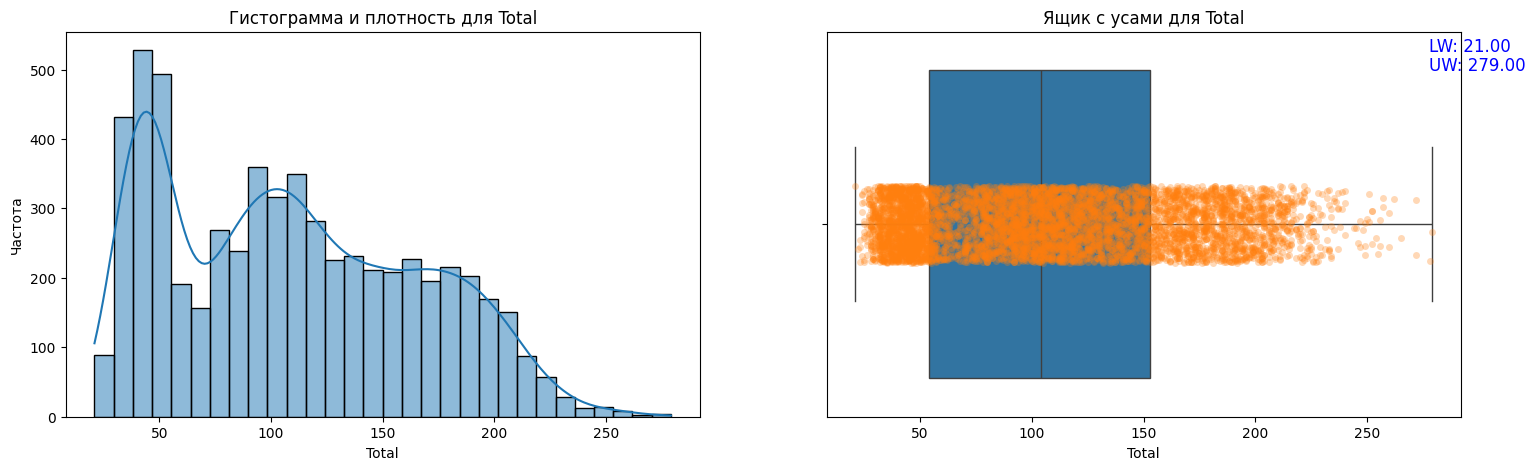

In [19]:
cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total' ] 
for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    sns.histplot(source[col], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Гистограмма и плотность для {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')

    stats = source[col].describe()
    q1 = stats['25%']  
    q3 = stats['75%']  
    iqr = q3 - q1 
    lower_whisker = max(stats['min'], q1 - 1.5 * iqr)
    upper_whisker = min(stats['max'],q3 + 1.5 * iqr)
    axes[1].text(0.95, 0.95, f'LW: {lower_whisker:.2f}', transform=axes[1].transAxes, fontsize=12, color='blue')
    axes[1].text(0.95, 0.90, f'UW: {upper_whisker:.2f}', transform=axes[1].transAxes, fontsize=12, color='blue')

    sns.boxplot(x=source[col], ax=axes[1])
    axes[1].set_title(f'Ящик с усами для {col}')
    axes[1].set_xlabel(col)
    sns.stripplot(x=source[col], ax=axes[1], alpha=0.3)
    
plt.show()

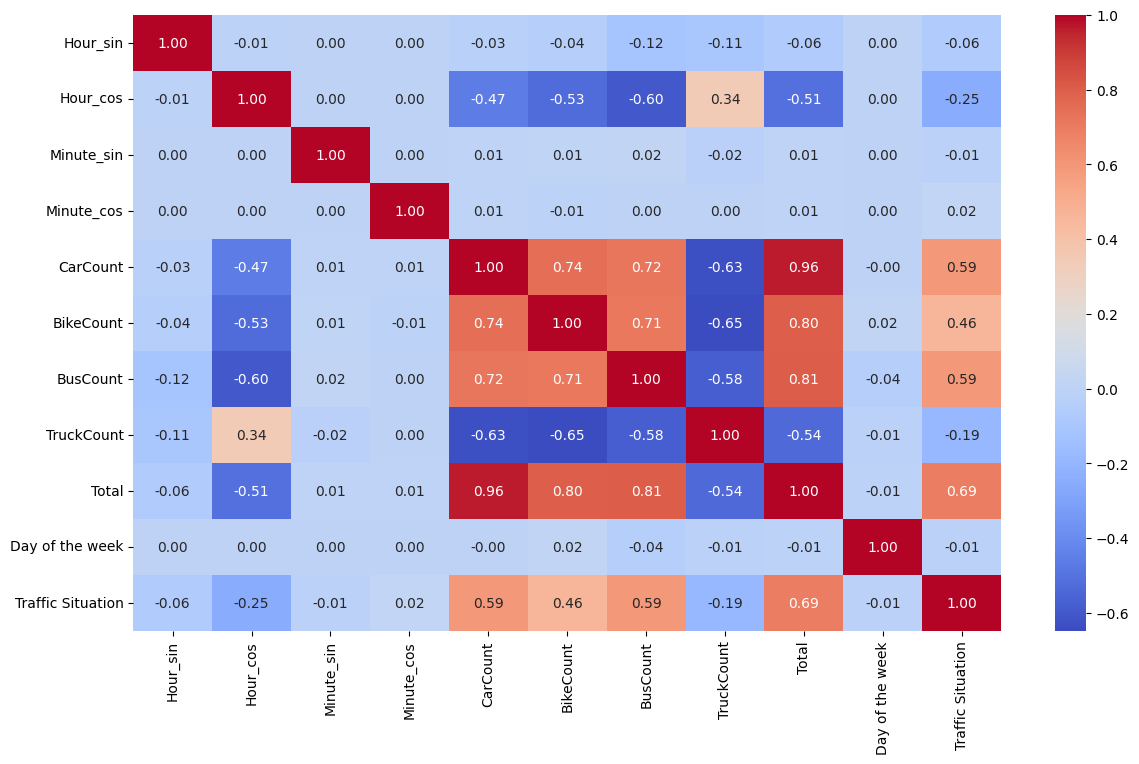

In [20]:
cols = ['Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Day of the week', 'Traffic Situation']
corr_matrix = source[cols].corr(method='spearman')
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [21]:
rows, cols = np.tril_indices_from(corr_matrix, k=-1)

for i, j in zip(rows, cols):
    corr_val = corr_matrix.iloc[i, j]
    if abs(corr_val) >= 0.45:
        col1, col2 = corr_matrix.index[i], corr_matrix.columns[j]
        print(f'{col1} и {col2} (corr = {corr_val:.2f})')

CarCount и Hour_cos (corr = -0.47)
BikeCount и Hour_cos (corr = -0.53)
BikeCount и CarCount (corr = 0.74)
BusCount и Hour_cos (corr = -0.60)
BusCount и CarCount (corr = 0.72)
BusCount и BikeCount (corr = 0.71)
TruckCount и CarCount (corr = -0.63)
TruckCount и BikeCount (corr = -0.65)
TruckCount и BusCount (corr = -0.58)
Total и Hour_cos (corr = -0.51)
Total и CarCount (corr = 0.96)
Total и BikeCount (corr = 0.80)
Total и BusCount (corr = 0.81)
Total и TruckCount (corr = -0.54)
Traffic Situation и CarCount (corr = 0.59)
Traffic Situation и BikeCount (corr = 0.46)
Traffic Situation и BusCount (corr = 0.59)
Traffic Situation и Total (corr = 0.69)


In [22]:
cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total' ] 
for col in cols:
    skew_val = source[col].skew()
    print(f'{col}: скос = {skew_val:.2f}')

CarCount: скос = 0.29
BikeCount: скос = 1.44
BusCount: скос = 0.95
TruckCount: скос = 0.32
Total: скос = 0.35


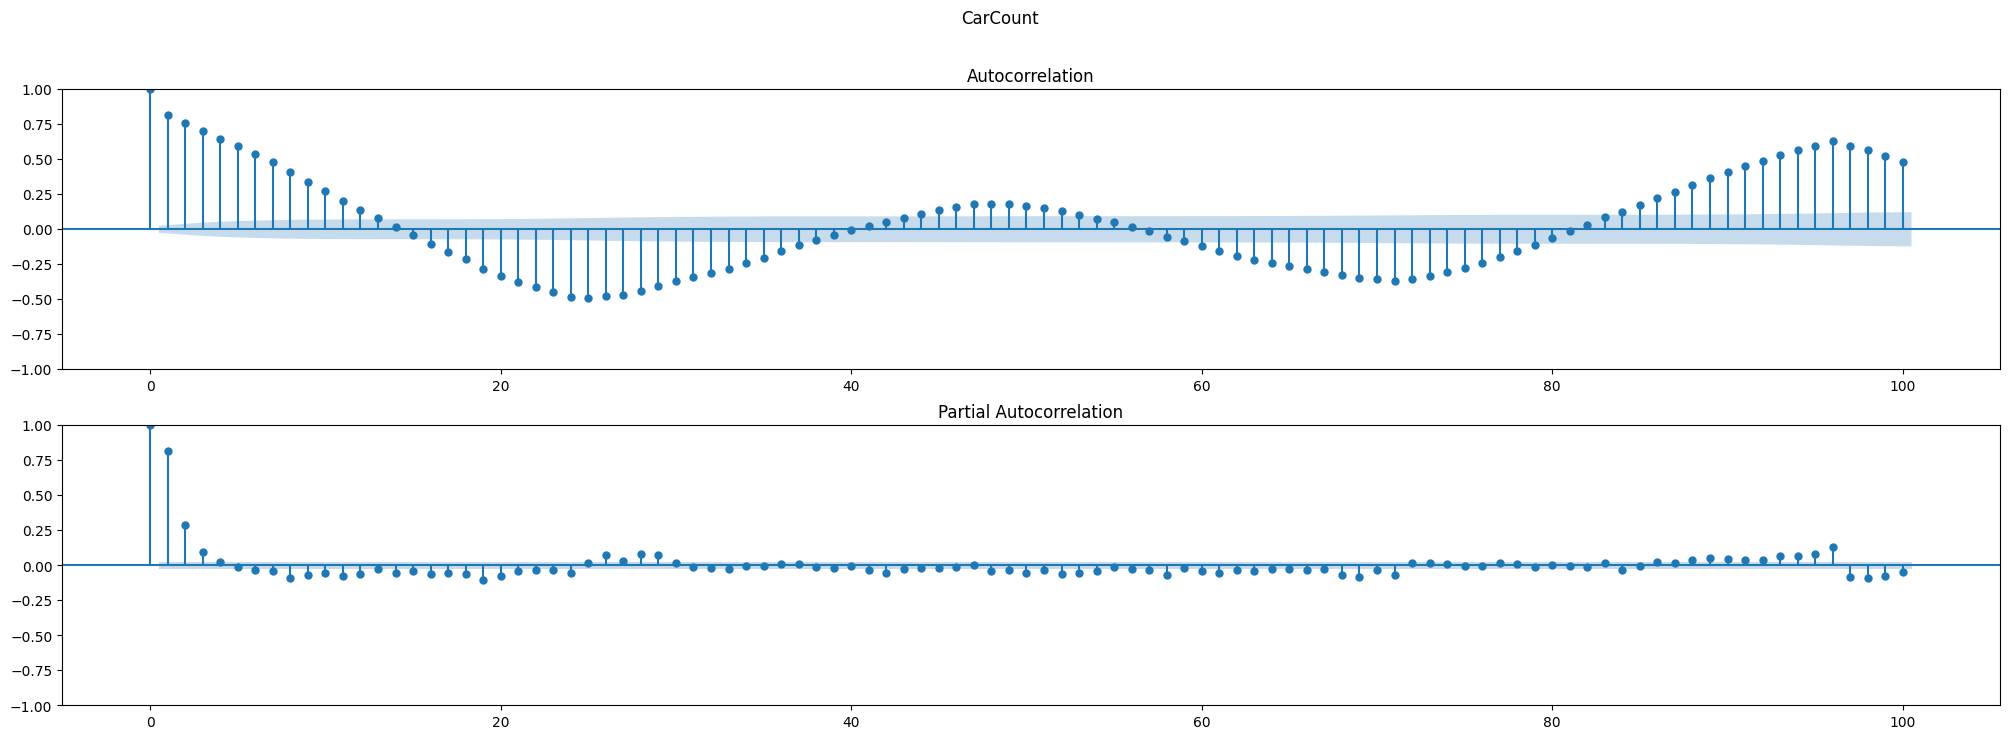

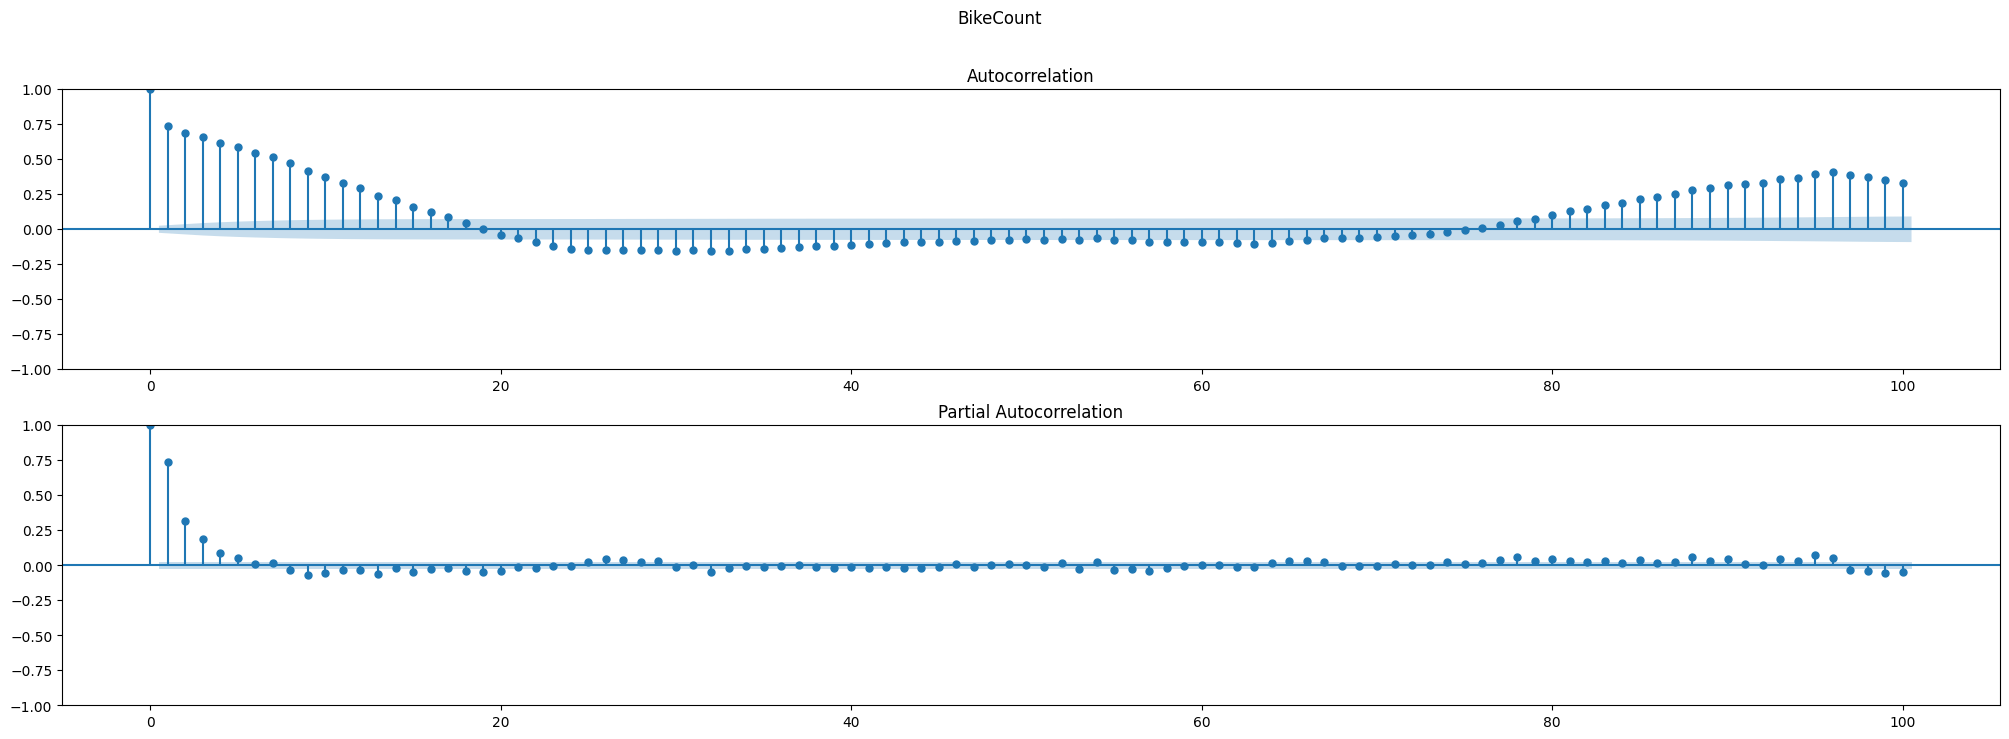

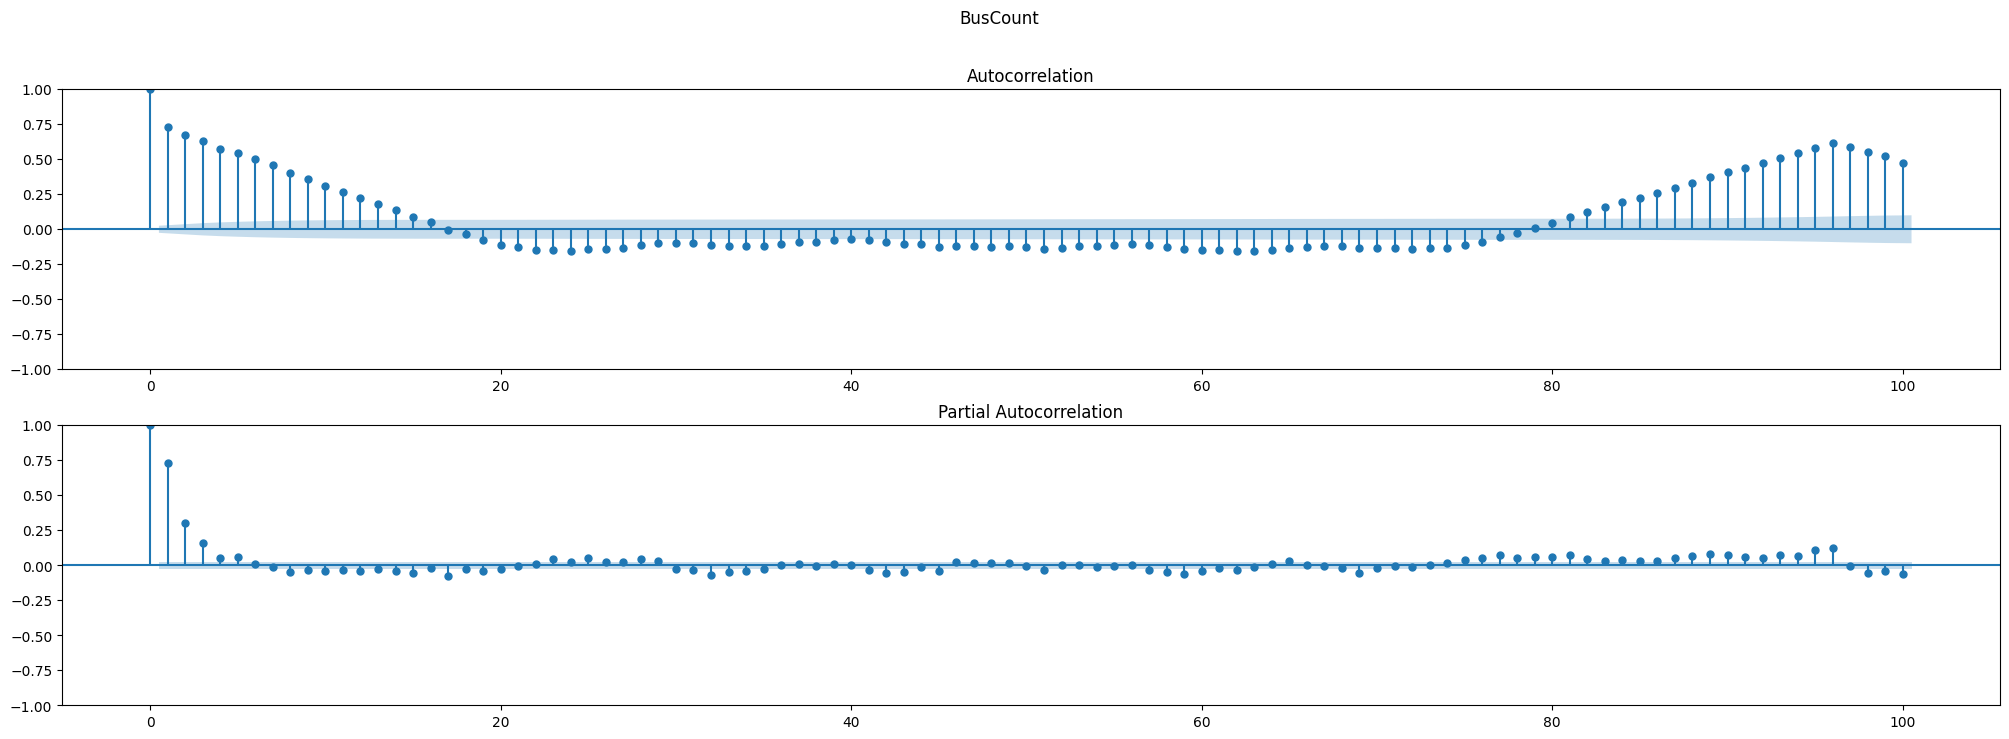

In [23]:
import statsmodels.api as sm

cols = ['CarCount', 'BikeCount', 'BusCount' ]

for col in cols:
    fig, axes = plt.subplots(2, 1, figsize=(25, 8))
    plt.suptitle(col)
    sm.graphics.tsa.plot_acf(source[col], lags=100, ax=axes[0])
    sm.graphics.tsa.plot_pacf(source[col], lags=100, ax=axes[1])
    plt.show()


In [24]:
cols = ['Time_24h','Hour', 'Minute', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'Traffic Situation', 'Minute_sin', 'Minute_cos', 'Hour_sin', 'Hour_cos', 'IsDay', 'Day of the week_cos', 'Day of the week_sin']
source[cols].to_csv('./data/raw.csv')


- Hour_sin отвечает за день, Hour_cos - за ночь 
    Q1 (cos>0, sin>0): Утро (00:00-06:00)
    Q2 (cos<0, sin>0): День (06:00-12:00)
    Q3 (cos<0, sin<0): Вечер (12:00-18:00)
    Q4 (cos>0, sin<0): Ночь (18:00-24:00)\
- ADF-статистика – это расчётное значение теста (чем отрицательнее, тем лучше).
- p-value – вероятность ошибиться, отвергая гипотезу о нестационарности. Нужно около 0
- Если p-value < 0.05 (или ADF-статистика < критического значения):
    - Отвергаем H₀ ⇒ ряд стационарен.
- Если p-value > 0.05 (или ADF-статистика > критического значения):
    - Не отвергаем H₀ ⇒ ряд нестационарен.